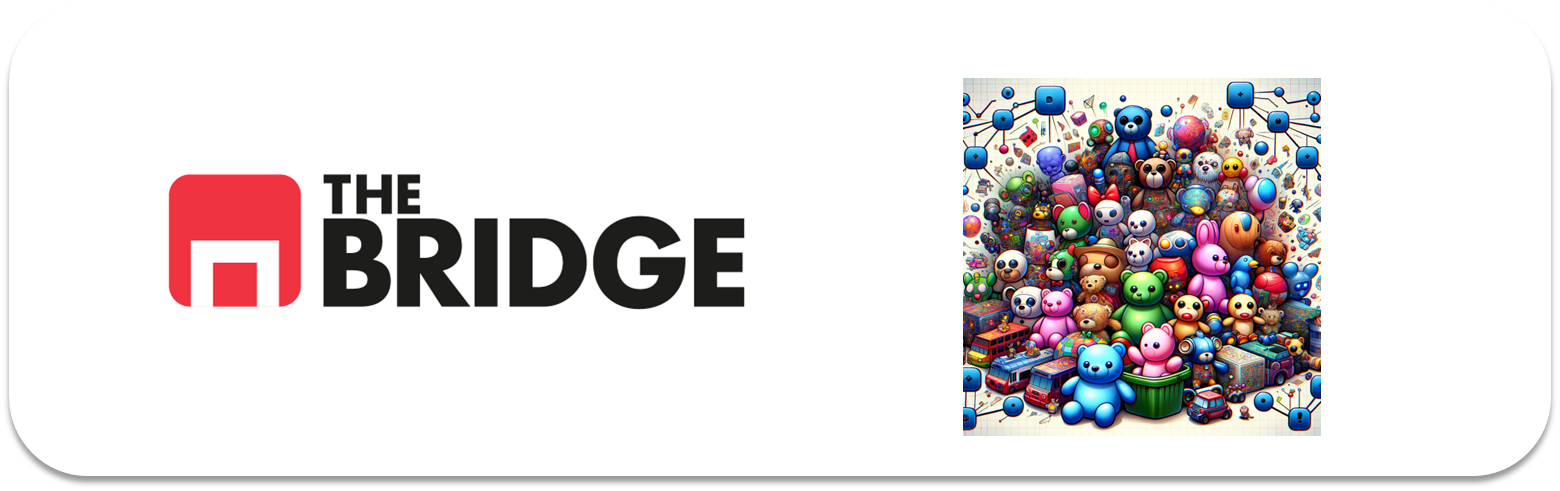

## Clustering No Jerárquico (I): K-Means


### Configuración

Para comenzar ejecuta la siguiente celda que está únicamente dedicada a hacer los imports y configuraciones necesarias para poder funcionar correctamente con este notebook de apoyo.

In [1]:
# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

### Introducción – Clasificación _vs_ Agrupamiento (Agrupamiento)

#### Agrupamiento o clustering no supervisado (sin target).

El Clustering no supervisado es la tarea de reconocer algun objeto y asignarlo a grupos de instancias similares sin definir las caracteristicas concretas de esos grupos (sin ponerles el TARGET).
Solo los etiqueta como grupo 1, grupo 2, grupo 3.. sin darle un sentido semantico inicial. 



In [2]:
# Para verlo usamos el dataset del iris

from sklearn.datasets import load_iris

In [3]:
data = load_iris()
X = data.data
y = data.target
data.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [4]:
data['feature_names']

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

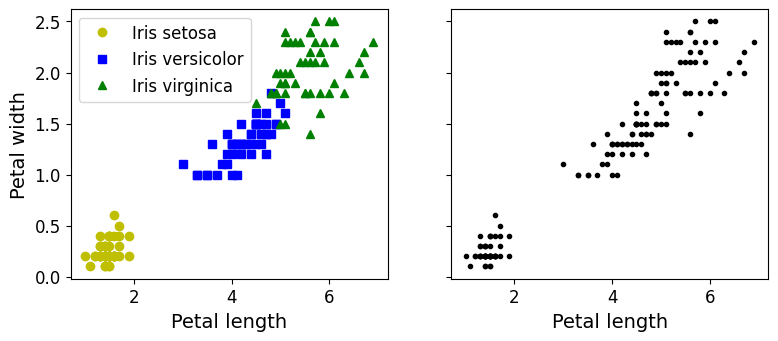

In [5]:
# Pintamos el data set distinguiendo por colores cada una de las clases, pero solo lo hacemos con la longitud del petalo a su ancho.
# Tambien lo vemos sin ponerle etiqueta, solo con puntos negros. 

plt.figure(figsize=(9, 3.5))

plt.subplot(121)
plt.plot(X[y==0, 2], X[y==0, 3], "yo", label="Iris setosa")
plt.plot(X[y==1, 2], X[y==1, 3], "bs", label="Iris versicolor")
plt.plot(X[y==2, 2], X[y==2, 3], "g^", label="Iris virginica")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(fontsize=12)

plt.subplot(122)
plt.scatter(X[:, 2], X[:, 3], c="k", marker=".")
plt.xlabel("Petal length", fontsize=14)
plt.tick_params(labelleft=False)


plt.show();

El dataset representado a la izquierda es el que usaríamos con un modelo supervisado para hacer la clasificación. El dataset representado a la derecha es, en cambio, el que tendríamos si no tuvieramos etiquetas y el que entregaríamos a un algoritmo no supervisado como kmeans. Es lo que vamos a hacer en la siguiente celda (ojo es solo a título ilustrativo)

En el caso que solo tenemos el de los puntos negros, vamos a ver que hay dos partes del grafico que se pueden agrupar, por lo que se separaria en dos en este caso.. por lo menos al principio. 

In [6]:
from sklearn.cluster import KMeans # 
k = 3 # K indica el numero de clusters que queremos que nos genere. 
kmeans = KMeans(n_clusters=k, random_state=101)

y_pred = kmeans.fit_predict(X) # no son predicciones, son etiquetados.. no puede predecir nada porque no hay un target como para comparar. 

# Me va a dar una lista de etiquetas de los clusters, para cada uno de los puntos que hay en x. 

# Los 0s del kmeans en realidad son los 1s del dataset y viceversa (ajuste para comparar)
mapping = np.array([1, 0, 2])
y_pred = np.array([mapping[cluster_id] for cluster_id in y_pred])

# Lo mapea primero para luego pintarlos. 

Pintemos la salida y comparémosla al caso supervisado:

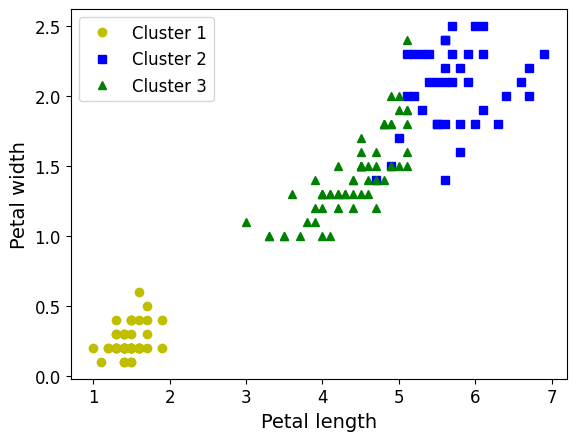

In [7]:
plt.plot(X[y_pred==0, 2], X[y_pred==0, 3], "yo", label="Cluster 1")
plt.plot(X[y_pred==1, 2], X[y_pred==1, 3], "bs", label="Cluster 2")
plt.plot(X[y_pred==2, 2], X[y_pred==2, 3], "g^", label="Cluster 3")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=12)
plt.show()

No lo ha hecho nada mal. Pero ojo, antes de que se te haga un lío el cerebro, fijate en las etiquetas de la leyenda. El algoritmo ha encontrado una agrupación con esos nombres, no puede decir si corresponden a un tipo u otro de flor, sólo lo hacemos nosotros porque tenemos la versión "supervisada". En un realidad en la que no la tuvieramos sólo tendríamos esa clasificación (la de la imagen) y no su explicación. A partir de ahí trabajaríamos.

$$*$$

### K-Means

Un poco de "wikiconocimiento": El algoritmo k-means es un algoritmo sencillo capaz de hacer clusteing de datos de manera muy rápida y eficiente, a menudo en solo unas pocas iteraciones. Fue propuesto por Stuart Lloyd en Bell Labs en 1957 pero solo se publicó fuera de la compañía en 1982.⁠ En 1965, Edward W. Forgy había publicado prácticamente el mismo algoritmo, por lo que a veces se conoce como el algoritmo Lloyd-Forgy.


Otro detalle es que tenemos que darle nosotros el número de agrupaciones o clusters que queremos por lo que k se convierte en un hiperparámetro del algoritmo y tendremos que buscar una forma de optimizarlo. [Veremos alguna técnica en sesiones posterores]

$$*$$

Para ir profundizando en el algoritmo nos vamos a crear un dataset "sintético". Empecemos generando algunos "blobs" (manchurrones en mi traducción algeceriña):

In [8]:
from sklearn.datasets import make_blobs

Lo primero es generarnos unos "centroides". ¿Centro... qué?

#### **Centroide**

El centroide dicho brutamente es el centro de un cluster o agrupación, es el punto promedio (es decir el que tiene como valores de sus features la media de cada feature). Aquí tienes una definición formal (pero para luego), ahora quedate con que lo que tenemos es que dar el "centro" de los manchurrones o clusters sintéticos que queremos crear.


**Definición Formal:**
En geometría, el centroide o baricentro de una figura plana o un sólido es el punto en el que se podría considerar que está concentrada toda la masa de la figura para propósitos de cálculos de balance y momento. Matemáticamente, el centroide de un conjunto de puntos $(x_i, y_i, z_i)$ (piensa en x,y,z como las features) en un espacio tridimensional se calcula como el promedio aritmético de todas las coordenadas de los puntos. En términos de fórmula, si tenemos $n$ puntos, el centroide $(C_x, C_y, C_z)$ se calcula como:


$$C_x = \frac{1}{n}\sum_{i=1}^{n} x_i, \quad C_y = \frac{1}{n}\sum_{i=1}^{n} y_i, \quad C_z = \frac{1}{n}\sum_{i=1}^{n} z_i$$

En el contexto del aprendizaje automático y el análisis de clusters, un centroide es el punto que representa el centro de un cluster, calculado como el promedio de todas las observaciones (puntos de datos) en ese cluster. En algoritmos como K-means, los centroides son claves para determinar la pertenencia de los puntos de datos a diferentes grupos o clusters.

In [9]:
'''
Defino los centroides de mis datos sinteticos y su dispersion
Es simplemente para crear la muestra de datos
'''
blob_centroides = np.array([[0.2, 2.3],
                            [-1.5, 2.3],
                            [-2.8, 1.8],
                            [-2.8,2.8],
                            [-2.8, 1.3]])


Y para crear puntos en torno a esos centroides me defino una desviación estándar (Ojo nada de esto es fundamental, sólo para describir e ilustrar este proceso (en cuanto acabe la sesión puedes resetearlo)

In [10]:

blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])

In [11]:
X, y = make_blobs(n_samples = 2000,
                  centers = blob_centroides,
                  cluster_std = blob_std,
                  random_state = 15)


Ahora vamos a representarlos (y al tiempo definiremos una función que nos servirá posteriormente para visualizar los ejemplos):

In [12]:
def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)


Vamos a añadir el centroide de cada "manchurrón" para visualizar el concepto:

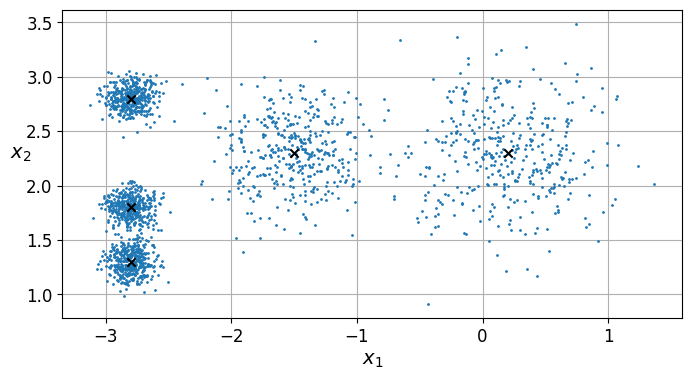

In [13]:
plt.figure(figsize=(8, 4))
plot_clusters(X)
plt.gca().set_axisbelow(True)
plt.grid()
for centroide in blob_centroides:
    plt.scatter(x = centroide[0], y = centroide[1], marker = "x", c = "black")
plt.show()




***

### Aplicación de Kmeans: Fit and Predict (Ajuste y predicción)

Ahora vamos a entrenar un clusterizador K-Means en el conjunto de datos sintéticos de "manchurrones". Intentará encontrar el centro de cada mancha (el centroide) y asignar cada instancia a la mancha más cercana (es decir a la mancha cuyo centroide este a menor distancia de la instancia):

In [14]:
from sklearn.cluster import KMeans

In [15]:
# Comprobamos como el KMeans divide en clusters
k = 5 # Lo tenemos que poner nosotros -> hiperparámetro
kmeans = KMeans(n_clusters = k,
                random_state =  4,
                n_init = 10) # que repita 10 veces el algoritmo y que se quede con la combinacion mas interesante

y_pred = kmeans.fit_predict(X) # Fit -> Obten centroides, predict -> asigna cluster (de los k posibles)
y_pred

# Podemos hacerlo en dos pasos:
# kmeans.fit(X)
# y_pred = kmeans.predict(X)

array([4, 4, 3, ..., 0, 3, 4], dtype=int32)

En $y_{pred}$ tenemos la asignacion de clusters para cada una de las instancias de nuestro dataset de train (aquí no hay "test", no es supervisado, ojo). Pero eso no quiere decir que a partir de ahora no podamos "clusterizar" (asignar a un clúster) cualquier dato nuevo que nos venga:

In [17]:
kmeans.predict([[-2,2.5]]) # Doble corchete porque esperar un array de instancias 

array([3], dtype=int32)

Lo pone en el cluster 3

[Un momento Jaime, no se supone que no es un clasificador, no como clasficador supervisado, aunque haya asignado esa instancia con valores de feature -2 y 2.5, quién nos dice que eso es correcto, no lo sabemos ni en teoría lo podremos saber, en cuyo caso convertiríamos el dataset en supervisado y a correr. Pude agrupar no podemos saber si es agrupación es correta porque en no supervisados de partida no hay clases correctas. Otra cosa es que luego viendo lo que ha salido en el clustering nosotros le demos sentido y el clustering nos sirva para etiquetar, por ejemplo]

Volviendo a nuestro ejemplo, cada instancia fue asignada a uno de los 5 clusters:

In [18]:
print(y_pred)
print(y_pred is kmeans.labels_)

[4 4 3 ... 0 3 4]
True


Y los siguientes 5 _centroides_ (es decir, centros de cluster) fueron estimados:

In [19]:
kmeans.cluster_centers_

array([[-2.79769606,  1.29691863],
       [-2.79486621,  2.80634881],
       [ 0.20194078,  2.28688569],
       [-1.48596019,  2.3145888 ],
       [-2.80056785,  1.80212092]])

En este caso, y sólo en este que hemos creado el dataset artificialmente, podemos comparar los centroides estimados con los reales:

In [20]:
blob_centroides

array([[ 0.2,  2.3],
       [-1.5,  2.3],
       [-2.8,  1.8],
       [-2.8,  2.8],
       [-2.8,  1.3]])

No esta mal, ¿verdad? (vale deja de mirarlos en orden y comprueba que el primero de los estimados es el tercero que le dimos nosotros, el segundo estimado es el primero, etc, recuerda que el algoritmo no tiene referencias)

Respecto al índice del cluster que se asigna depende del orden de obtención de los centroides. En nuestro caso los puntos más cercanos al primero estimado recibirán la etiqueta 0.

In [21]:
'''
Esta etiqueta es el indice del cluster. Sirve para relacionarlo con
kmeans.cluster_centers_. El primer centroide corresponde a la etiqueta 0
'''
for i in range(5):
    print(f"X1={X[i,0]}, X2 = {X[i,1]} -> label: {kmeans.labels_[i]}")

X1=-2.8271528107048978, X2 = 1.5902320438691129 -> label: 4
X1=-2.8629761247307077, X2 = 1.7191437228470188 -> label: 4
X1=-1.2006199614308943, X2 = 2.6042609257463063 -> label: 3
X1=-0.14429693356516166, X2 = 2.2709398245422157 -> label: 2
X1=0.232391361111047, X2 = 2.132823714575191 -> label: 2


Y ahora pintemos las agrupaciones (ojo al truco con la función que nos creamos antes)

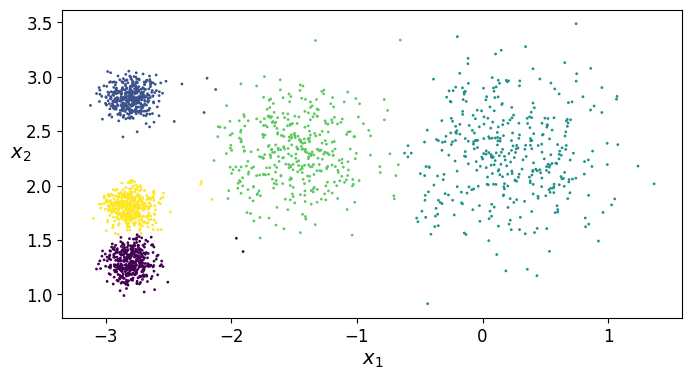

In [22]:
plt.figure(figsize=(8, 4))
plot_clusters(X, y = kmeans.predict(X)) # y realmente es el color, no el eje y
plt.show()

No tiene mala pinta, pero claro recuerda que en la vida real no tendremos la referencia de que cluster o agrupación tiene sentido.

***

### Límites de decisión

Vamos a trazar los límites de decisión del modelo. Esto nos dará los que se denomina un *diagrama de Voronoi*. Vamos a utilizar las siguientes funciones que no son fundamentales para tu aprendizaje.

In [23]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='b'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=15, linewidths=20,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

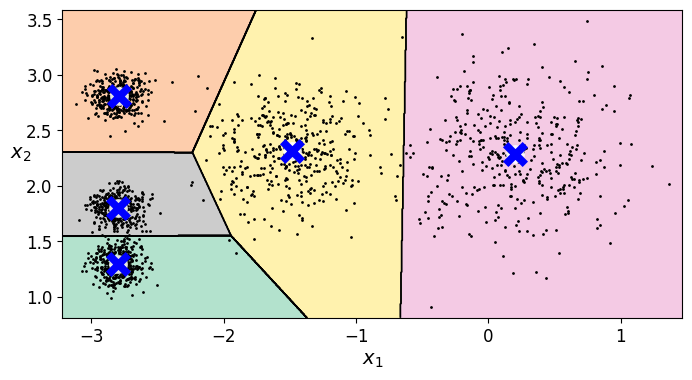

In [24]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X)
plt.show()

¡No está mal! Es probable que algunas de las instancias cercanas a los bordes hayan sido asignadas al clúster incorrecto, pero en general parece bastante bueno. (Bueno aquí se refiere a que sería el clustering que ahríamos nosotros a ojo, sólo  que aquí el kmeans nos simplifica la tarea, una aplicación de automatización interesante sin duda)

### Hard Clustering _vs_ Soft Clustering

En lugar de elegir arbitrariamente el clúster más cercano para cada instancia, lo cual se denomina _hard_clustering_, podría ser mejor medir la distancia de cada instancia a los 5 centroides y luego nosotros implementar un mecanismo de decisión alternativo. Esto es lo que hace el método `transform()`, devolvernos las distancias de cada instancia a los centroides.

In [25]:
'''
Como hard voting vs soft voting en los ensembles
'''
# Supongamos que nos llegan nuevos datos:
X_new = np.array([[0, 2], [3, 2], [-3, 3], [-3, 2.5]])


Hard-clustering: nos da el cluster cuyo centroide está más cerca de la instancia

In [26]:
kmeans.predict(X_new)

array([2, 2, 1, 1], dtype=int32)

Soft-Clustering: nos da las distancias a cada centroide y podemos implementar un mecanismo diferente

In [27]:
'''
La distancia de cada punto a predecir de cada cluster. Puede ser una buena manera
de reducir el dataset a k dimensiones.
'''
kmeans.transform(X_new)

array([[2.88468831, 2.90886155, 0.35083255, 1.51889559, 2.80754989],
       [5.84017149, 5.85069849, 2.812728  , 4.49697731, 5.80394207],
       [1.71505482, 0.28210043, 3.28038973, 1.6619582 , 1.21436711],
       [1.219972  , 0.36868613, 3.20902516, 1.5253504 , 0.72581567]])

Puedes verificar que esta es, de hecho, la distancia euclidiana entre cada instancia y cada centroide:

In [ ]:
'''
np.tile y el reshape repite X_new 4 veces, para calcular mejor los puntos vs los centros. Luego se calcula la norma,
que es la distancia euclídea
'''
np.linalg.norm(np.tile(X_new, (1, k)).reshape(-1, k, 2) - kmeans.cluster_centers_, axis=2)

***

### K-Means Algorithm

### Algoritmo K-Means

**Funcionamiento teórico**

El algoritmo K-Means es uno de los algoritmos de agrupamiento más rápidos, pero también uno de los más simples:

* Primero inicializa $k$ centroides de forma aleatoria: se eligen de forma aleatoria $k$ instancias distintas del conjunto de datos y se colocan los centroides en sus ubicaciones. [Es decir se escogen k instancias y esas son los primeros centroides]
* Ahora se asignan todas las instancias al cluster que corresponda al centroide del que están más cerca.
* Hecha esta elección se recalculan los centroides de cada cluster (es decir se hace el promedio de las features de cada instancia de cada cluster y ese es el nuevo centroide) y se vuelve a empezar... es decir
* Repetir hasta la convergencia (es decir, hasta que los centroides dejen de moverse, en general esto implica que los centroides nuevos no distan más de un valor de tolerancia del centroide anterior o bien hasta un número determinado de repeticiones del recálculo de centroides):
    * Asignar cada instancia al centroide más cercano.
    * Actualizar los centroides para que sean la media de las instancias que están asignadas a ellos.

Realmente, la clase `KMeans` aplica por defecto versión optimizada del algoritmo anterior. Para obtener el algoritmo original de K-Means (solo con fines educativos), debes establecer `init="random"` y `n_init=1`. Estos hiperparámetros se explicarán a continuación.

'Vamos a ejecutar el algoritmo K-Means durante 1, 2 y 3 iteraciones, para ver cómo se mueven los centroides alrededor:'

In [28]:
'''
init: varias maneras de inicializar los clusters, por defecto una más eficiente que random. Random -> es elección aleatoria de los centroides.
n_init: numero de veces que se repite el algoritmo con diferentes centroides de inicio. 
        Luego se escoge la clusterizacion o la repetición con la mejor puntuación en una 
        métrica que veremos un poco más adelante, la inercia o inertia.
max_iter: numero de veces que recalculará centroides
'''
kmeans_iter1 = KMeans(n_clusters = 5, 
                      init = 'random', 
                      n_init = 1, 
                      max_iter = 1, # 
                      random_state = 24)


kmeans_iter2 = KMeans(n_clusters = 5, 
                      init = 'random', 
                      n_init = 1, 
                      max_iter = 2, 
                      random_state = 24)


kmeans_iter3 = KMeans(n_clusters = 5, 
                      init = 'random', 
                      n_init = 1, 
                      max_iter = 3, 
                      random_state = 24)


kmeans_iter1.fit(X)
kmeans_iter2.fit(X)
kmeans_iter3.fit(X)

KMeans(init='random', max_iter=3, n_clusters=5, n_init=1, random_state=24)

Creamos tres kmeans y vemos que ocurre con los centroides (fijate que al utilizar la misma semilla, cada modelo/algoritmo escogerá los mismos centroides de partida). Así podremos ver los centroides tras la primera selección, la segunda y la tercera.

Y vamos a pintar como se mueven los centroides y por tanto las zonas de decisión:

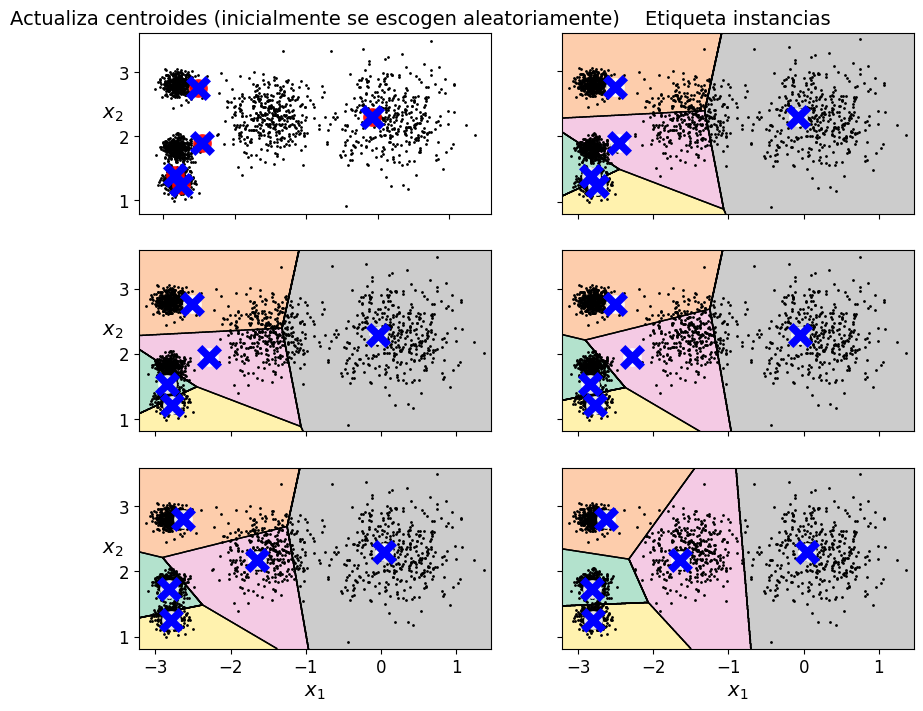

In [29]:
plt.figure(figsize=(10, 8))

# Pintamos los centroides del primer modelo que solo ha hecho una iteración es decir los centroides elegidos aleatoriamente (no se han llegado a actualizar)
plt.subplot(321) # 321 -> 3 filas, 2 columnas, elemento 1 (fila 0, columna 0)
plot_data(X)
plot_centroids(kmeans_iter1.cluster_centers_, circle_color='r', cross_color='b')
plt.ylabel("$x_2$", fontsize=14, rotation=0)
plt.tick_params(labelbottom=False)
plt.title("Actualiza centroides (inicialmente se escogen aleatoriamente)", fontsize=14)

# Pintamos los boundaries, es decir es como "etiquetamos las instancias"
plt.subplot(322) # 322 -> 3 filas, 2 columnas, elemento 2 (fila 0, columna 1)
plot_decision_boundaries(kmeans_iter1, X, show_xlabels=False, show_ylabels=False)
plt.title("Etiqueta instancias", fontsize=14)

# Sobre la elección anterior, pintamos los centroides de la segunda iteración es decir los centroides recalculados
plt.subplot(323)
plot_decision_boundaries(kmeans_iter1, X, show_centroids=False, show_xlabels=False)
plot_centroids(kmeans_iter2.cluster_centers_)

# pintamos las nuevas zonas de elección
plt.subplot(324)
plot_decision_boundaries(kmeans_iter2, X, show_xlabels=False, show_ylabels=False)

# pintamos los centroides de la tercera iteración
plt.subplot(325)
plot_decision_boundaries(kmeans_iter2, X, show_centroids=False)
plot_centroids(kmeans_iter3.cluster_centers_)

# pintamos la clusterización de la tercera iteración
plt.subplot(326)
plot_decision_boundaries(kmeans_iter3, X, show_ylabels=False)


plt.show()

### Variabilidad de K-Means

En el algoritmo original de K-Means, los centroides simplemente se inicializan al azar, y el algoritmo simplemente realiza una sola iteración para mejorar gradualmente los centroides, como vimos anteriormente.

Sin embargo, un problema importante con este enfoque es que si se ejecuta K-Means varias veces (o con diferentes semillas aleatorias), puede converger a soluciones muy diferentes, como se puede ver a continuación:

In [30]:
'''
Ejemplo de ejecucion de kmeans con dos semillas diferentes. Debido al inicio random, convergerá de manera diferente
Solucionamos con la inertia. Inicializamos varias veces, y el que tenga mejor inertia o inercia que es una métrica que veremos en la siguiente sesión.
'''
def plot_clusterer_comparison(clusterer1, clusterer2, X, title1=None, title2=None):
    clusterer1.fit(X)
    clusterer2.fit(X)

    plt.figure(figsize=(10, 3.2))

    plt.subplot(121)
    plot_decision_boundaries(clusterer1, X)
    if title1:
        plt.title(title1, fontsize=14)

    plt.subplot(122)
    plot_decision_boundaries(clusterer2, X, show_ylabels=False)
    if title2:
        plt.title(title2, fontsize=14)

Creamos dos clusterings que se van a ejecutar completos pero empezando con centroides diferentes y vamos a ver como agrupan cada uno por separado.

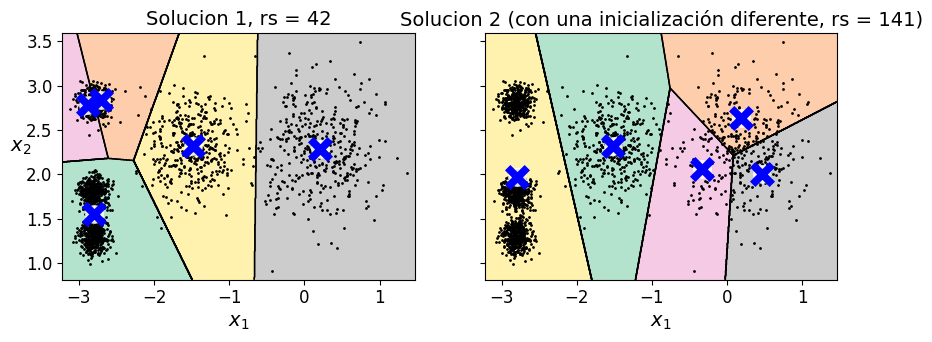

In [31]:
kmeans_rnd_init1 = KMeans(n_clusters = 5, init = 'random', n_init=1, random_state = 42)
kmeans_rnd_init2 = KMeans(n_clusters = 5, init = 'random', n_init=1, random_state = 141)

plot_clusterer_comparison(kmeans_rnd_init1, kmeans_rnd_init2, X,
                          "Solucion 1, rs = 42", "Solucion 2 (con una inicialización diferente, rs = 141)")


plt.show()

¿Cuál debería considerar como mejor? Para ello veremos en la siguiente sesión la métrica que aplica internamente k-means para decidir de varias posibles clasificaciones cuál es mejor.

***

### Inercia (Inertia)

Para seleccionar el mejor modelo, necesitaremos una forma de evaluar el rendimiento de un modelo de K-Means. Desafortunadamente, la agrupación es una tarea no supervisada, por lo que no tenemos targets y no podemos emplear algo como la precision o el recall.  

Pero al menos podemos medir la distancia entre cada instancia y su centroide y a partir de ahí sacar una métrica. Esta es la idea detrás de la métrica de _inercia_ o *inertia* (en inglés):

In [32]:
'''
La suma de las distancias al cuadrado de cada punto a cada centroide
Cuanto más baja la inertia, más cerca están los puntos de los centroides y en teoria la agrupación es "mejor" 
'''
kmeans_rnd_init1.inertia_

266.60597954696686

In [33]:
kmeans_rnd_init2.inertia_

625.7421301887274

Como puedes verificar fácilmente, la inercia es la suma de las distancias al cuadrado entre cada instancia de entrenamiento y su centroide más cercano:

In [34]:
X_dist = kmeans_rnd_init1.transform(X) # Obtenemos la distancia de cada instancia a los centroides
sum(X_dist[np.arange(len(X_dist)), kmeans_rnd_init1.labels_]**2) # Mira que forma tan "ingeniosa" de calcular la inercia

266.605979546967

Otra forma de calcularla (aplicada al segundo kmeans)

In [35]:
inercia = 0
for indice,vector in enumerate(X): # Vamos a recorrer todas las instancias, en concreto sus clusters asignados
    clase_asignada = kmeans_rnd_init2.labels_[indice]
    distancia = np.linalg.norm(vector - kmeans_rnd_init2.cluster_centers_[clase_asignada])
    distancia_al_cuadrado = distancia**2
    inercia += distancia_al_cuadrado
print(inercia)

625.7421301887265


Considerando esta métrica (cuanto mmenos inercia mejor), el primer cluster es mejor que el segundo (visualmente también lo parece)

Además no vas a tener que hacer cálculos, tienes el atributo `inertia_` y el método `score()` devuelve la inercia negativa. ¿Por qué negativa? Bueno, es porque el método `score()` de un predictor siempre debe respetar la regla "_mientras más grande, mejor_".

In [36]:
# Objetivo: minimizar la inertia
kmeans_rnd_init1.score(X)

-266.6059795469668

Muy bien y esto ¿de qué nos sirve? Pues para aliviar el problema de tener la dependencia de empezar con centroides aleatorios.

### Múltiples Inicializaciones

Un enfoque para resolver el problema de variabilidad es simplemente ejecutar el algoritmo K-Means varias veces con diferentes inicializaciones aleatorias, y seleccionar la solución que minimice la inercia. Por ejemplo, aquí están las inercias de los dos modelos "malos" mostrados en la figura anterior:

In [37]:
kmeans_rnd_init1.inertia_

266.60597954696686

In [38]:
kmeans_rnd_init2.inertia_

625.7421301887274

Y la inercia del primer modelo, que nos gustaba :

In [39]:
kmeans.inertia_

218.5357897191712

Como puedes ver, tienen una inercia mayor que el primer modelo "bueno" que entrenamos, lo que significa que probablemente son peores.

Cuando estableces el hiperparámetro `n_init`, Scikit-Learn ejecuta el algoritmo original `n_init` veces, y selecciona la solución que minimiza la inercia.

In [40]:
kmeans_rnd_10_init = KMeans(n_clusters = 5, init = 'random', n_init=10, random_state = 29)
kmeans_rnd_10_init.fit(X)

KMeans(init='random', n_clusters=5, n_init=10, random_state=29)

Como puedes ver, terminamos con el modelo inicial, que ciertamente es la solución óptima de K-Means (al menos en términos de inercia, y asumiendo $k=5$).

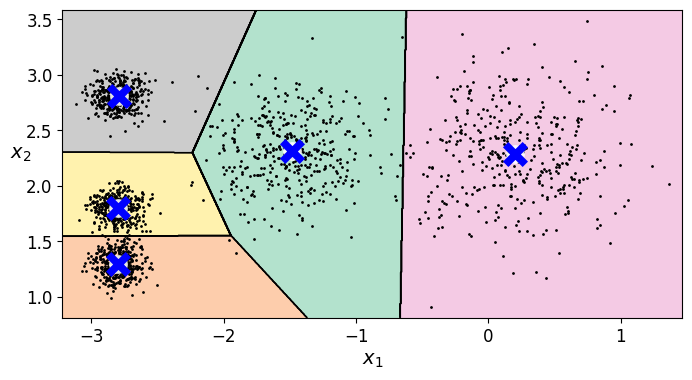

In [41]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans_rnd_10_init, X)
plt.show()

Pero la inercia no sólo sirve para que internamente el algoritmo decida cual de todos sus "intentos" es el mejor, sino que también nos puede servir para encontrarel valor de k más interesante (recuerda que es un hiperparámetro)

***

### Encontrar el número óptimo de clústeres

#### Mediante la inercia

Si la inercia es nuestra métrica de bondad de un modelo de clustering parece claro que una forma de encontrar el $k$ óptimo sería ir probando valores y quedarnos con el que de lugar a un agrupamiento con la inercia menor.... Pero veamos antes de aferrarnos a ello qué sucedería si el número de clústeres se estableciera en un valor inferior o superior a 5

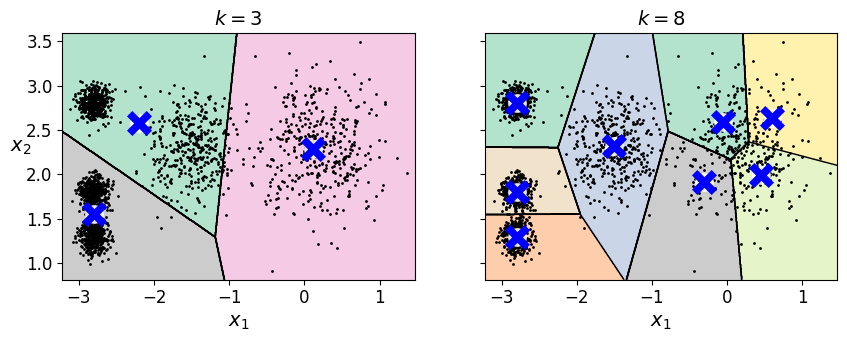

In [42]:
'''
Conseguir un modelo con la intertia baja, no quiere decir que sea el mejor.
Quiza otra cantidad de clusters sea mas apropiada
Cuantos mas k, menor es la intertia, pero ¿hasta cuando paramos k? -> Elbow
'''
kmeans_k3 = KMeans(n_clusters=3, random_state=42)
kmeans_k8 = KMeans(n_clusters=8, random_state=42)

plot_clusterer_comparison(kmeans_k3, kmeans_k8, X, "$k=3$", "$k=8$")
plt.show()

No parecen muy buenos. Veamos sus inercias:

In [43]:
kmeans_k3.inertia_

645.1463798380547

In [44]:
kmeans_k8.inertia_

136.634927524656

No, no podemos simplemente tomar el valor de $k$ que minimiza la inercia, ya que esta sigue disminuyendo a medida que incrementamos $k$. De hecho, mientras más grupos haya, cada instancia estará más cerca de su centroide más cercano, y por lo tanto la inercia será menor. Sin embargo, podemos pintar la inercia como una función de $k$ y analizar la curva resultante:

In [45]:
kmeans_per_k = [KMeans(n_clusters=k, random_state= 42, n_init = 25).fit(X)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

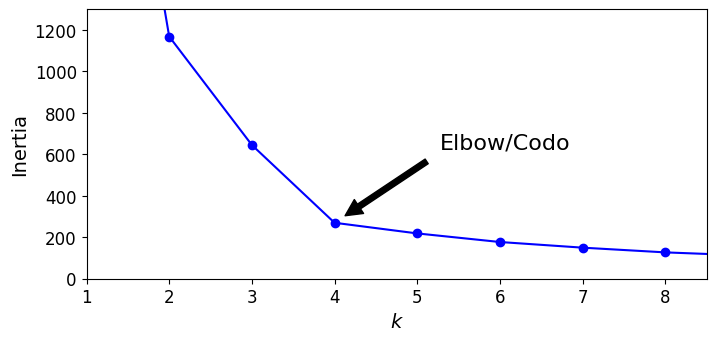

In [46]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow/Codo',
             xy=(4, inertias[3]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.axis([1, 8.5, 0, 1300])
plt.show()

Como puedes ver, hay un codo en $k=4$, lo que significa que menos clusters que eso sería malo, y más clusters no ayudarían mucho y podrían dividir a los clusters a la mitad. Así que $k=4$ es una elección bastante buena. Por supuesto, en este ejemplo no es perfecto, ya que significa que las dos manchas en la esquina inferior izquierda se considerarán como un solo cluster, pero sigue siendo un agrupamiento bastante bueno.

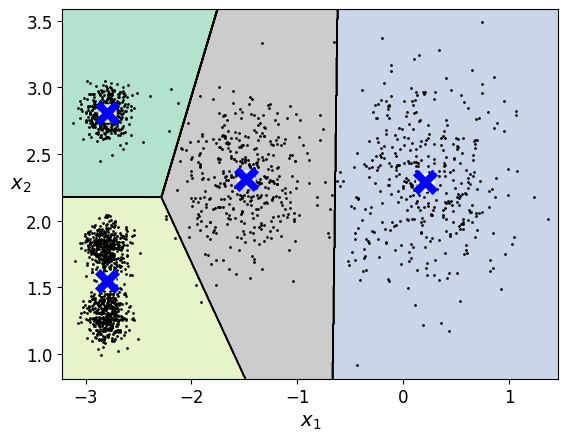

In [47]:
plot_decision_boundaries(kmeans_per_k[4-1], X)
plt.show()

***

### Mediante las siluetas

Lo primero será definir que es eso de la silueta y con calma que no es de digestión rápida:

**Coeficiente de silueta**, es una medida que se aplica instancia a instancia del dataset una vez ya asociada a un clúster por el algoritmo. Se define (lee y escucha con tranquilidad) como:

$$(b - a)/\max(a, b)$$

donde $a$ es la distancia media a las otras instancias en el mismo clúster (es la _distancia media intra-clúster_), y $b$ es la _distancia media al clúster más cercano_, es decir, la distancia media a las instancias del siguiente clúster más cercano (definido como el que minimiza $b$, excluyendo el clúster de la propia instancia)

**El coeficiente de silueta puede variar entre -1 y +1: un coeficiente cercano a +1 significa que la instancia está bien dentro de su propio clúster y lejos de otros clústeres, mientras que un coeficiente cercano a 0 significa que está cerca de un límite de clúster, y finalmente un coeficiente cercano a -1 significa que la instancia puede haber sido asignada al clúster incorrecto.**

Ojo nosotros vamos a trabajar con el promedio (es decir la suma de todos los coeficientes de silueta dividio por el número de instancias del dataset), que también se denomina "silhoutte_score" (y que siguiendo el razonamiento anterior puede ir de -1 a +1 y que cuanto más positivo mejor)

[Mostrar a mano como se haría el cálculo para un punto]

Vamos a trazar el puntaje de la silueta como una función de $k$:

In [48]:
from sklearn.metrics import silhouette_score

In [49]:
silhouette_score(X, kmeans.labels_)

0.6495652979643829

Empleando la lista de modelos k-means para k diferentes de la sesión anterior obtenemos el score de silueta para cada uno y lo pintamos

In [51]:
silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in kmeans_per_k[1:]]

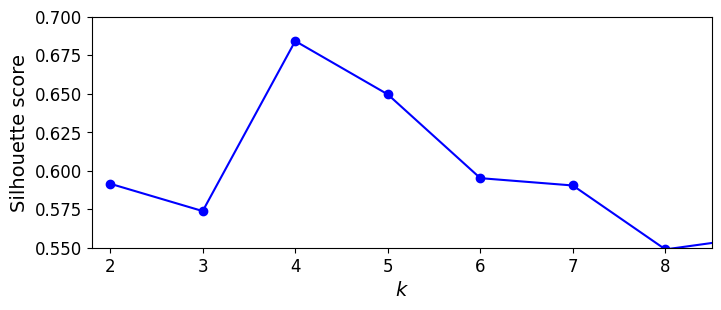

In [52]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.axis([1.8, 8.5, 0.55, 0.7])
plt.show()

Como puedes ver, esta visualización es mucho más rica que la anterior: en particular, aunque confirma que $k=4$ es una muy buena elección, también subraya el hecho de que $k=5$ es igualmente bueno.

An even more informative visualization is given when you plot every instance's silhouette coefficient, sorted by the cluster they are assigned to and by the value of the coefficient. This is called a _silhouette diagram_:

Un diagrama de silueta proporciona una visualización aún más informativa cuando se traza el coeficiente de silueta de cada instancia, ordenado por el clúster al que están asignados y por el valor del coeficiente. Esto se conoce como un _diagrama de silueta_:

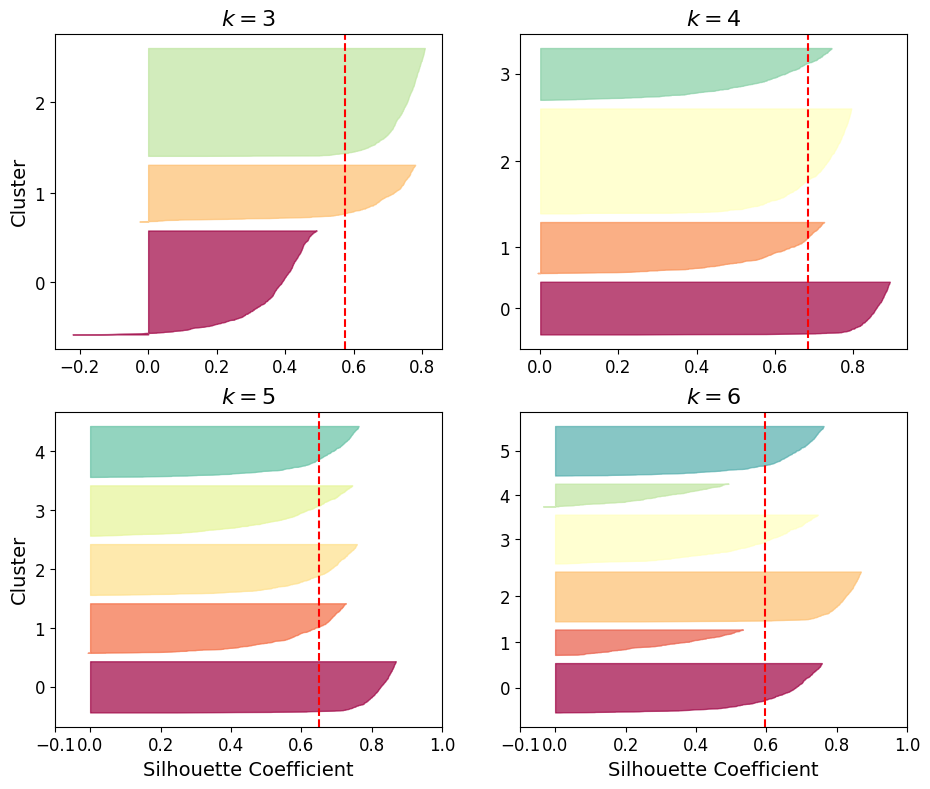

In [53]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

'''
La anchura de cada cuchillo representa el numero de muestras por cluster. Están ordenadas
por su coeficiente de silhouette, por eso tiene esa forma de cuchillo. Cuanta más caida tenga
indica que las muestras tienen un coeficiente mas disperso en ese cluster
Deberian estar todos los clusters por encima de la media.
Hay algunas lineas hacia la izda xq es el coeficiente negativo. Puntos asignados al cluster erroneo.
'''
plt.figure(figsize=(11, 9))

for k in (3, 4, 5, 6):
    plt.subplot(2, 2, k - 2)
    
    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)

    padding = len(X) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")
    
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=True)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)


plt.show()

En nuestro caso, observa que en $k=4$ y $k=5$, todos los "cuchillos" (los clusters) tienen instancias que superan el coeficiente medio (el score de silueta), pero no es el caso de $k=3$ y $k=6$, refuerza que son mejores valores para k

### Límites de K-Means

In [54]:
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

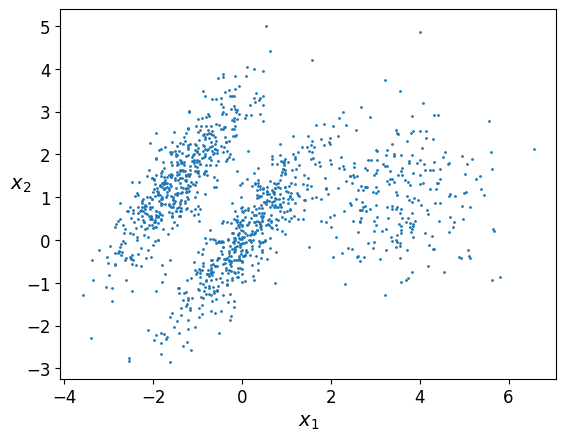

In [55]:
'''
Con algunas formas de clusters no se comporta muy bien el kmeans. En
este ejemplo, mejores clasificaciones provoca peores inertias.
'''
plot_clusters(X)

In [56]:
kmeans_good = KMeans(n_clusters = 3, 
                     init = np.array([[-1.5, 2.5], [0.5,0], [4,0]]), # Esta es la forma de darle nosotros los centroides
                     n_init = 1, 
                     random_state = 42)

kmeans_bad = KMeans(n_clusters = 3, random_state = 19)   

kmeans_good.fit(X)
kmeans_bad.fit(X)

KMeans(n_clusters=3, random_state=19)

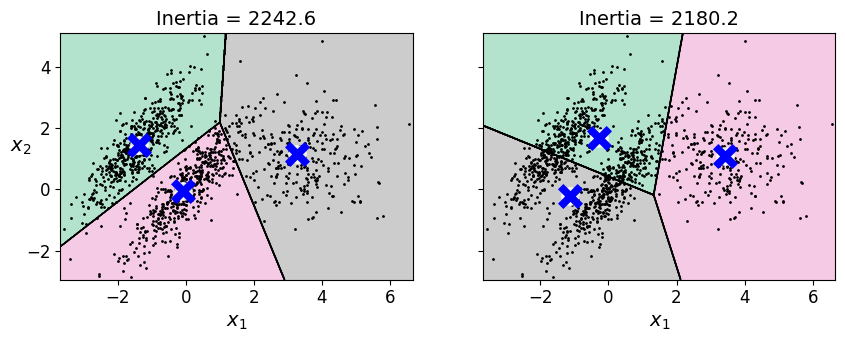

In [57]:
plt.figure(figsize=(10, 3.2))

plt.subplot(121)
plot_decision_boundaries(kmeans_good, X)
plt.title("Inertia = {:.1f}".format(kmeans_good.inertia_), fontsize=14)

plt.subplot(122)
plot_decision_boundaries(kmeans_bad, X, show_ylabels=False)
plt.title("Inertia = {:.1f}".format(kmeans_bad.inertia_), fontsize=14)


plt.show()